In [1]:
import torch
import torchvision
import torchvision.transforms as transforms
import numpy as np
import torch.nn as nn
import torch.nn.functional as F
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

In [2]:
import inspect
# from scipy import linalg
import numpy as np
print(inspect.getsource(np.linalg.svd))

@array_function_dispatch(_svd_dispatcher)
def svd(a, full_matrices=True, compute_uv=True, hermitian=False):
    """
    Singular Value Decomposition.

    When `a` is a 2D array, and ``full_matrices=False``, then it is
    factorized as ``u @ np.diag(s) @ vh = (u * s) @ vh``, where
    `u` and the Hermitian transpose of `vh` are 2D arrays with
    orthonormal columns and `s` is a 1D array of `a`'s singular
    values. When `a` is higher-dimensional, SVD is applied in
    stacked mode as explained below.

    Parameters
    ----------
    a : (..., M, N) array_like
        A real or complex array with ``a.ndim >= 2``.
    full_matrices : bool, optional
        If True (default), `u` and `vh` have the shapes ``(..., M, M)`` and
        ``(..., N, N)``, respectively.  Otherwise, the shapes are
        ``(..., M, K)`` and ``(..., K, N)``, respectively, where
        ``K = min(M, N)``.
    compute_uv : bool, optional
        Whether or not to compute `u` and `vh` in addition to `s`.  True
 

In [3]:
#  Download and load CIFAR-10 dataset
transform = transforms.Compose([transforms.Grayscale(num_output_channels=1), transforms.ToTensor()])
trainset = torchvision.datasets.CIFAR10(root='./data', train=True, download=True, transform=transform)
trainloader = torch.utils.data.DataLoader(trainset, batch_size=64, shuffle=True)

testset = torchvision.datasets.CIFAR10(root='./data', train=False, download=True, transform=transform)
testloader = torch.utils.data.DataLoader(testset, batch_size=64, shuffle=False)

def compute_svd_singular_values(image_batch):
    singular_values = []
    for image in image_batch:
        squeeze = image.squeeze()
        U, S, V = torch.svd(squeeze)
        singular_values.append(S)
    return torch.stack(singular_values)

# Compute singular values for train and test sets
train_singular_values = [compute_svd_singular_values(batch[0]).to(device) for batch in trainloader]
test_singular_values = [compute_svd_singular_values(batch[0]).to(device) for batch in testloader]

Files already downloaded and verified
Files already downloaded and verified


In [4]:
len(train_singular_values[0])

64

### Step 2: Neural Network Training

#### A. Define the Neural Network Model

In [5]:
class SVDPredictor(nn.Module):
    def __init__(self):
        super(SVDPredictor, self).__init__()
        self.fc1 = nn.Linear(32*32, 512)
        self.fc2 = nn.Linear(512, 256)
        self.fc3 = nn.Linear(256, 32)  # Predicting 32 singular values

    def forward(self, x):
        x = F.relu(self.fc1(x))
        x = F.dropout(x, p=0.5)
        x = F.relu(self.fc2(x))
        x = F.dropout(x, p=0.5)
        return self.fc3(x)

# move the model to gpu
model = SVDPredictor().to(device)

#### B. Define Loss Function and Optimizer

In [6]:
import torch.optim as optim

criterion = nn.L1Loss()
optimizer = optim.Adam(model.parameters(), lr=0.00001)


#### C. Training the Model

In [11]:
# Training loop
num_epochs = 50  # Set the number of epochs
print_every_n_batches = 100  # Print log after every 100 batches

train_losses = []  # 记录每个epoch的训练损失

for epoch in range(num_epochs):
    running_loss = 0.0
    for i, (images, _) in enumerate(trainloader):
        images = images.view(images.shape[0], -1).to(device)
        labels = train_singular_values[i]  # Precomputed singular values

        optimizer.zero_grad()
        outputs = model(images)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()

        running_loss += loss.item()

        # Log the running loss
        # if (i + 1) % print_every_n_batches == 0:
        #     print(f'Epoch [{epoch + 1}/{num_epochs}], Step [{i + 1}/{len(trainloader)}], Loss: {running_loss / print_every_n_batches:.4f}')
        #     running_loss = 0.0
    epoch_loss = running_loss / len(trainloader)
    train_losses.append(epoch_loss)
    print(f'Epoch [{epoch + 1}/{num_epochs}], Loss: {epoch_loss:.4f}')
print('Finished Training')



Epoch [1/50], Loss: 0.2230
Epoch [2/50], Loss: 0.2223
Epoch [3/50], Loss: 0.2223
Epoch [4/50], Loss: 0.2222
Epoch [5/50], Loss: 0.2222
Epoch [6/50], Loss: 0.2220
Epoch [7/50], Loss: 0.2224
Epoch [8/50], Loss: 0.2217
Epoch [9/50], Loss: 0.2224
Epoch [10/50], Loss: 0.2213
Epoch [11/50], Loss: 0.2215
Epoch [12/50], Loss: 0.2216
Epoch [13/50], Loss: 0.2219
Epoch [14/50], Loss: 0.2214
Epoch [15/50], Loss: 0.2214
Epoch [16/50], Loss: 0.2207
Epoch [17/50], Loss: 0.2214
Epoch [18/50], Loss: 0.2215
Epoch [19/50], Loss: 0.2215
Epoch [20/50], Loss: 0.2215
Epoch [21/50], Loss: 0.2206
Epoch [22/50], Loss: 0.2210
Epoch [23/50], Loss: 0.2210
Epoch [24/50], Loss: 0.2201
Epoch [25/50], Loss: 0.2206
Epoch [26/50], Loss: 0.2206
Epoch [27/50], Loss: 0.2204
Epoch [28/50], Loss: 0.2201
Epoch [29/50], Loss: 0.2204
Epoch [30/50], Loss: 0.2199
Epoch [31/50], Loss: 0.2201
Epoch [32/50], Loss: 0.2201
Epoch [33/50], Loss: 0.2204
Epoch [34/50], Loss: 0.2206
Epoch [35/50], Loss: 0.2204
Epoch [36/50], Loss: 0.2201
E

### Step 3: Evaluation


##### Implementing NMSE and MAE Computation

In [12]:
def compute_nmse(outputs, labels):
    mse = ((outputs - labels) ** 2).mean(axis=1)
    norm = (labels ** 2).mean(axis=1)
    nmse = mse / norm
    return nmse

def compute_mae(outputs, labels):
    mae = torch.abs(outputs - labels).mean(axis=1)
    return mae


In [13]:
model.eval()  # Set the model to evaluation mode

total_nmse = torch.Tensor().to(device)  # Use PyTorch tensor for efficiency
total_mae = torch.Tensor().to(device)
total_samples = 0

val_losses = []  # 记录每个epoch的验证损失

with torch.no_grad():
    for epoch in range(num_epochs):
        running_val_loss = 0.0
        for i, (images, _) in enumerate(testloader):
            images = images.view(images.shape[0], -1).to(device)
            labels = test_singular_values[i].to(device)  # Use precomputed singular values

            outputs = model(images)
            nmse = compute_nmse(outputs, labels)
            mae = compute_mae(outputs, labels)

            total_nmse = torch.cat((total_nmse, nmse.unsqueeze(0)), dim=1)  # Efficiently concatenate tensors
            total_mae = torch.cat((total_mae, mae.unsqueeze(0)), dim=1)
            total_samples += images.size(0)
            val_loss = criterion(outputs, labels).item()
            running_val_loss += val_loss
        epoch_val_loss = running_val_loss / len(testloader)
        val_losses.append(epoch_val_loss)
        

# Convert to Python list for further processing if necessary
total_nmse = total_nmse.flatten().cpu().numpy()
total_mae = total_mae.flatten().cpu().numpy()


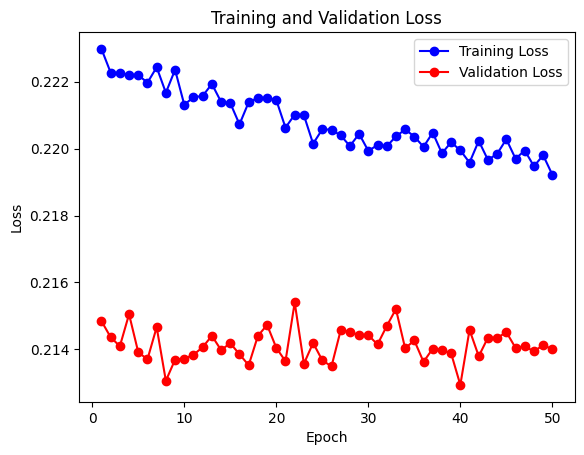

In [14]:
import matplotlib.pyplot as plt

epochs = range(1, num_epochs + 1)
plt.plot(epochs, train_losses, 'bo-', label='Training Loss')
plt.plot(epochs, val_losses, 'ro-', label='Validation Loss')
plt.title('Training and Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.show()


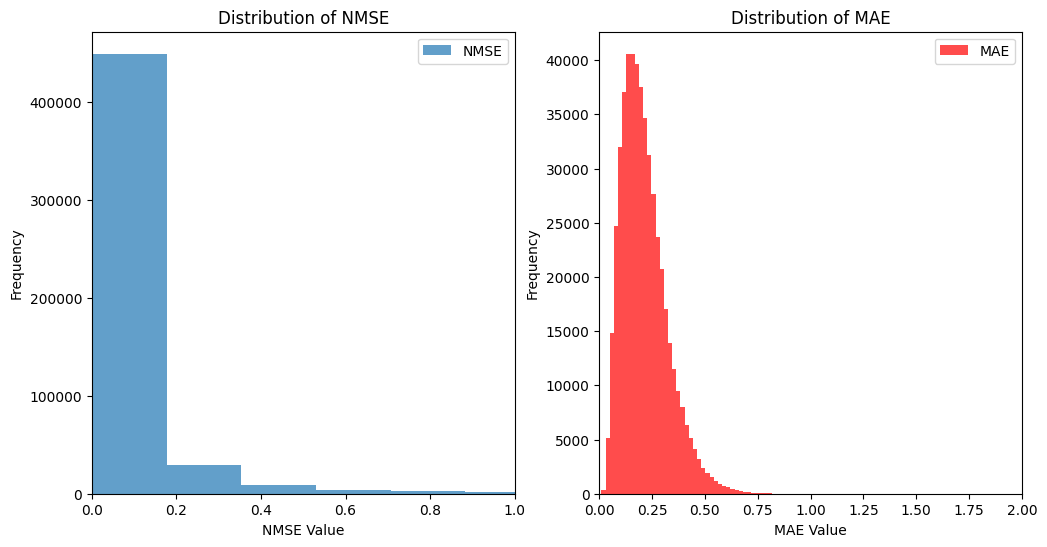

In [16]:
import matplotlib.pyplot as plt
import numpy as np

# 设置图形的大小
plt.figure(figsize=(12, 6))

# 绘制 NMSE 的分布
plt.subplot(1, 2, 1)  # 1行2列的第1个
plt.hist(total_nmse, bins=200, alpha=0.7, label='NMSE')
# plt.yscale('log')  # 如果需要，开启对数尺度
plt.xlabel('NMSE Value')
plt.ylabel('Frequency')
plt.title('Distribution of NMSE')
plt.xlim(0, 1)  # 根据实际数据范围设置
plt.legend()

# 绘制 MAE 的分布
plt.subplot(1, 2, 2)  # 1行2列的第2个
plt.hist(total_mae, bins=50, alpha=0.7, color='red', label='MAE')
plt.xlabel('MAE Value')
plt.ylabel('Frequency')
plt.title('Distribution of MAE')
plt.xlim(0, 2)  # 根据实际数据范围设置
plt.legend()

# 显示整个图表
plt.show()